# **Challenge: make your own regression model**

In [888]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [889]:
ny_crime = pd.read_csv('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.csv')

print(ny_crime.dtypes)

ny_crime.head()

City                                       object
Population                                 object
Violent\rcrime                             object
Murder and\rnonnegligent\rmanslaughter      int64
Rape\r(revised\rdefinition)1              float64
Rape\r(legacy\rdefinition)2                object
Robbery                                    object
Aggravated\rassault                        object
Property\rcrime                            object
Burglary                                   object
Larceny-\rtheft                            object
Motor\rvehicle\rtheft                      object
Arson3                                    float64
dtype: object


,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,"1,861",0,0,nan,0,0,0,12,2,10,0,0.000
1,Addison Town and Village,"2,577",3,0,nan,0,0,3,24,3,20,1,0.000
2,Akron Village,"2,846",3,0,nan,0,0,3,16,1,15,0,0.000
3,Albany,"97,956",791,8,nan,30,227,526,"4,090",705,"3,243",142,nan
4,Albion Village,"6,388",23,0,nan,3,4,16,223,53,165,5,nan


In [890]:
# Fill empty cells
ny_crime.fillna(0)

# Rename columns
ny_crime.columns = ['City', 'Population', 'Violent Crime', 'Murder', 'Rape definition 1', 'Rape definition 2', 'Robbery', 'Aggravated Assault', 'Property Crime', 'Burglary', 'Larceny-theft', 'Motor Vehicle Theft', 'Arson']

# Remove commas from numeric strings
ny_crime['Population'] = ny_crime['Population'].apply(lambda x: int(x.replace(',', '')))

ny_crime['Robbery'] = ny_crime['Robbery'].apply(lambda x: int(x.replace(',', '')))

ny_crime['Property Crime'] = ny_crime['Property Crime'].apply(lambda x: int(x.replace(',', '')))

print(ny_crime.dtypes)

ny_crime.head()

City                    object
Population               int64
Violent Crime           object
Murder                   int64
Rape definition 1      float64
Rape definition 2       object
Robbery                  int64
Aggravated Assault      object
Property Crime           int64
Burglary                object
Larceny-theft           object
Motor Vehicle Theft     object
Arson                  float64
dtype: object


,City,Population,Violent Crime,Murder,Rape definition 1,Rape definition 2,Robbery,Aggravated Assault,Property Crime,Burglary,Larceny-theft,Motor Vehicle Theft,Arson
0,Adams Village,1861,0,0,nan,0,0,0,12,2,10,0,0.000
1,Addison Town and Village,2577,3,0,nan,0,0,3,24,3,20,1,0.000
2,Akron Village,2846,3,0,nan,0,0,3,16,1,15,0,0.000
3,Albany,97956,791,8,nan,30,227,526,4090,705,"3,243",142,nan
4,Albion Village,6388,23,0,nan,3,4,16,223,53,165,5,nan


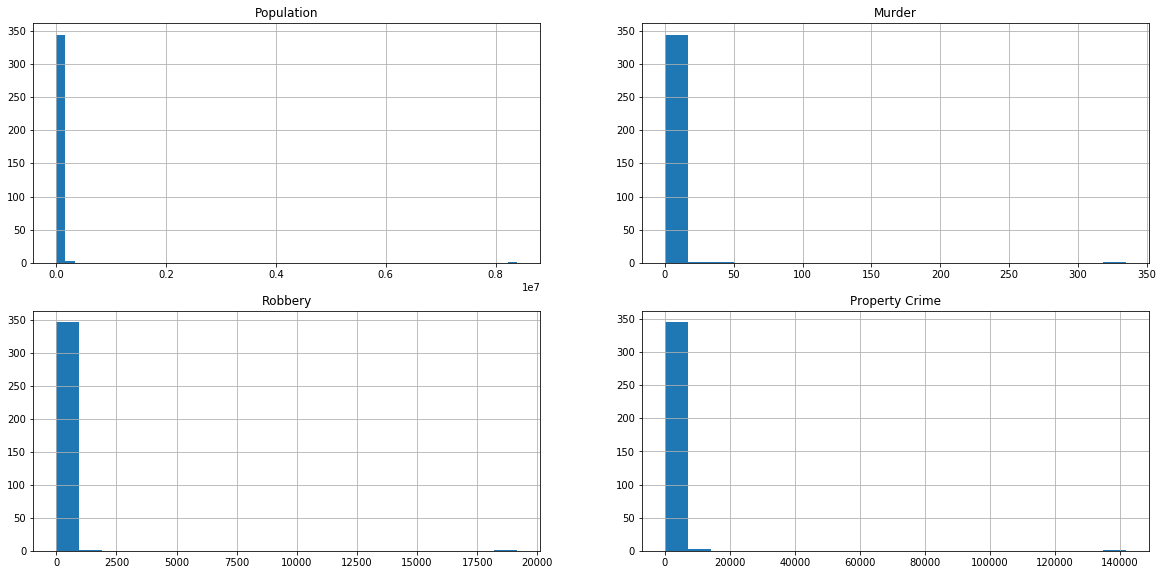

In [891]:
plt.figure(figsize=(20,15))
plt.subplot(321)
ny_crime['Population'].hist(bins=50)
plt.title('Population')

plt.subplot(322)
ny_crime['Murder'].hist(bins=20)
plt.title('Murder')

plt.subplot(323)
ny_crime['Robbery'].hist(bins=20)
plt.title('Robbery')

plt.subplot(324)
ny_crime['Property Crime'].hist(bins=20)
plt.title('Property Crime')

plt.show()

In [892]:
# Filter out any outliers over two standard deviations above the mean
pop_cutoff = ny_crime['Population'].mean() + 2*ny_crime['Population'].std()
mur_cutoff = ny_crime['Murder'].mean() + 2*ny_crime['Murder'].std()
rob_cutoff = ny_crime['Robbery'].mean() + 2*ny_crime['Robbery'].std()
prop_cutoff = ny_crime['Property Crime'].mean() + 2*ny_crime['Property Crime'].std()

ny_crime['Population'] = ny_crime['Population'].map(lambda x: x if x < pop_cutoff else None)
ny_crime['Murder'] = ny_crime['Murder'].map(lambda x: x if x < mur_cutoff else None)
ny_crime['Robbery'] = ny_crime['Robbery'].map(lambda x: x if x < rob_cutoff else None)
ny_crime['Property Crime'] = ny_crime['Property Crime'].map(lambda x: x if x < prop_cutoff else None)

ny_crime.describe()

,Population,Murder,Rape definition 1,Robbery,Property Crime,Arson
count,347.000,345.000,0.000,347.000,347.000,187.000
mean,15956.686,0.351,nan,17.867,385.752,1.872
std,27080.219,1.587,nan,94.972,1034.369,10.693
min,526.000,0.000,nan,0.000,0.000,0.000
25%,2997.000,0.000,nan,0.000,40.000,0.000
50%,7187.000,0.000,nan,1.000,112.000,0.000
75%,18160.500,0.000,nan,5.000,340.500,1.000
max,258789.000,21.000,nan,1322.000,12491.000,132.000


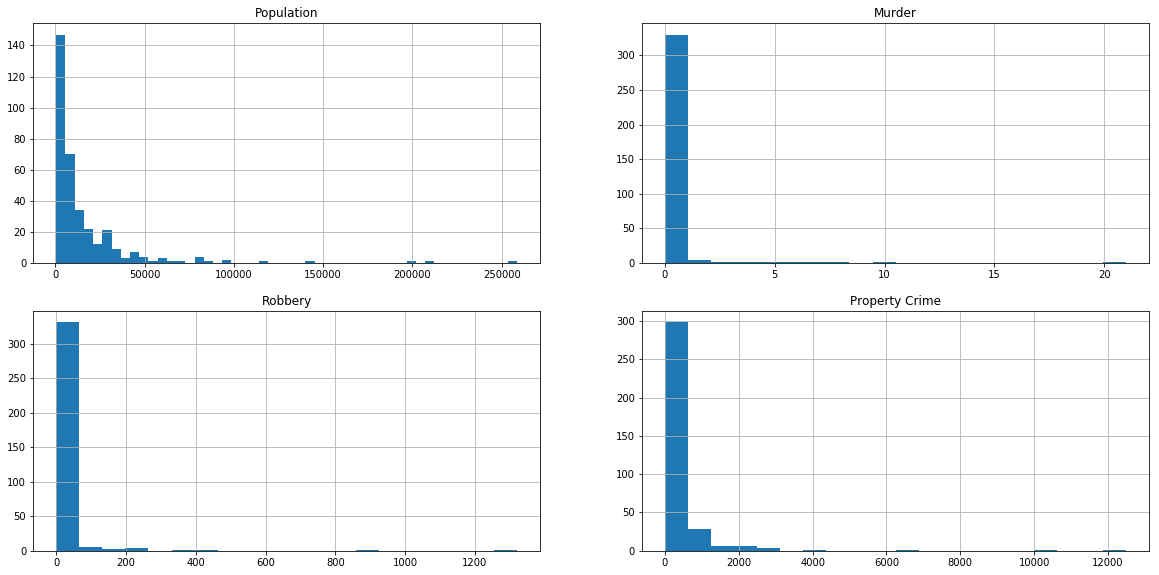

In [893]:
plt.figure(figsize=(20,15))
plt.subplot(321)
ny_crime['Population'].hist(bins=50)
plt.title('Population')

plt.subplot(322)
ny_crime['Murder'].hist(bins=20)
plt.title('Murder')

plt.subplot(323)
ny_crime['Robbery'].hist(bins=20)
plt.title('Robbery')

plt.subplot(324)
ny_crime['Property Crime'].hist(bins=20)
plt.title('Property Crime')

plt.show()

We can see that the range of the x-axis reduced in each case, which indicates that the extreme outliers have been removed. Now let's create a new feature for Population^2, as well as boolean features for Murder and Robbery.

In [894]:
# Create new feature
ny_crime['PopulationSq'] = ny_crime['Population']**2

ny_crime.head()

,City,Population,Violent Crime,Murder,Rape definition 1,Rape definition 2,Robbery,Aggravated Assault,Property Crime,Burglary,Larceny-theft,Motor Vehicle Theft,Arson,PopulationSq
0,Adams Village,1861.000,0,0.000,nan,0,0.000,0,12.000,2,10,0,0.000,3463321.000
1,Addison Town and Village,2577.000,3,0.000,nan,0,0.000,3,24.000,3,20,1,0.000,6640929.000
2,Akron Village,2846.000,3,0.000,nan,0,0.000,3,16.000,1,15,0,0.000,8099716.000
3,Albany,97956.000,791,8.000,nan,30,227.000,526,4090.000,705,"3,243",142,nan,9595377936.000
4,Albion Village,6388.000,23,0.000,nan,3,4.000,16,223.000,53,165,5,nan,40806544.000


In [895]:
ny_crime['Murder_cat'] = ny_crime['Murder'].apply(lambda x: 1 if x > 0 else 0)
ny_crime['Robbery_cat'] = ny_crime['Robbery'].apply(lambda x: 1 if x > 0 else 0)

ny_crime.head()

,City,Population,Violent Crime,Murder,Rape definition 1,Rape definition 2,Robbery,Aggravated Assault,Property Crime,Burglary,Larceny-theft,Motor Vehicle Theft,Arson,PopulationSq,Murder_cat,Robbery_cat
0,Adams Village,1861.000,0,0.000,nan,0,0.000,0,12.000,2,10,0,0.000,3463321.000,0,0
1,Addison Town and Village,2577.000,3,0.000,nan,0,0.000,3,24.000,3,20,1,0.000,6640929.000,0,0
2,Akron Village,2846.000,3,0.000,nan,0,0.000,3,16.000,1,15,0,0.000,8099716.000,0,0
3,Albany,97956.000,791,8.000,nan,30,227.000,526,4090.000,705,"3,243",142,nan,9595377936.000,1,1
4,Albion Village,6388.000,23,0.000,nan,3,4.000,16,223.000,53,165,5,nan,40806544.000,0,1


In [896]:
features = ny_crime[['Population', 'PopulationSq', 'Murder_cat', 'Robbery_cat', 'Property Crime']].dropna()
features.head()

,Population,PopulationSq,Murder_cat,Robbery_cat,Property Crime
0,1861.000,3463321.000,0,0,12.000
1,2577.000,6640929.000,0,0,24.000
2,2846.000,8099716.000,0,0,16.000
3,97956.000,9595377936.000,1,1,4090.000
4,6388.000,40806544.000,0,1,223.000


In [897]:
features.describe()

,Population,PopulationSq,Murder_cat,Robbery_cat,Property Crime
count,347.000,347.000,347.000,347.000,347.000
mean,15956.686,985840709.758,0.133,0.599,385.752
std,27080.219,5067232380.434,0.340,0.491,1034.369
min,526.000,276676.000,0.000,0.000,0.000
25%,2997.000,8982153.000,0.000,0.000,40.000
50%,7187.000,51652969.000,0.000,1.000,112.000
75%,18160.500,329804222.500,0.000,1.000,340.500
max,258789.000,66971746521.000,1.000,1.000,12491.000


In [898]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
data = features[['Population', 'PopulationSq', 'Murder_cat', 'Robbery_cat']]
target = features['Property Crime']
regr.fit(data, target)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(data, target))


Coefficients: 
 [  1.40107315e-02   1.13425350e-07   8.42401093e+01   1.00084978e+02]

Intercept: 
 -20.7925867491

R-squared:
0.842104946287


## **Linear Relationship**

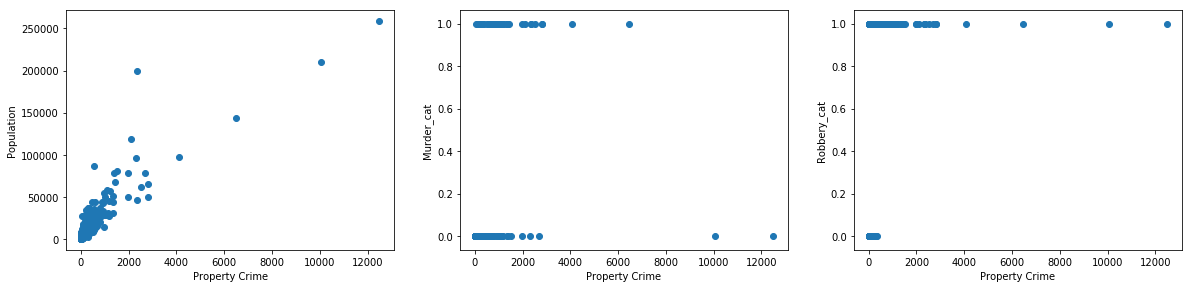

In [899]:
fig = plt.figure(figsize=(20,15))

fig.add_subplot(331)
plt.scatter(features['Property Crime'], features['Population'])
plt.xlabel('Property Crime')
plt.ylabel('Population')

fig.add_subplot(332)
plt.scatter(features['Property Crime'], features['Murder_cat'])
plt.xlabel('Property Crime')
plt.ylabel('Murder_cat')

fig.add_subplot(333)
plt.scatter(features['Property Crime'], features['Robbery_cat'])
plt.xlabel('Property Crime')
plt.ylabel('Robbery_cat')

plt.show()

## **Multivariate Normality**

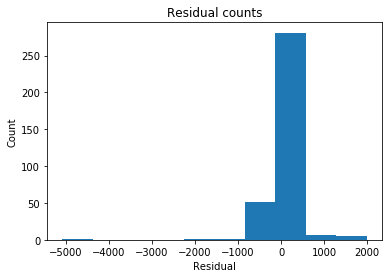

In [900]:
# Extract predicted values.
predicted = regr.predict(data).ravel()
actual = features['Property Crime']

# Calculate the error, also called the residual.
residual = actual - predicted

plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

## **Homoscedasticity**

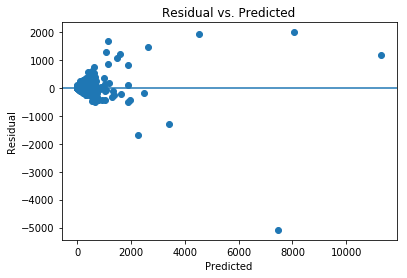

In [901]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

## **Low Multicollinearity**

In [902]:
correlation_matrix = data.corr()
display(correlation_matrix)

,Population,PopulationSq,Murder_cat,Robbery_cat
Population,1.000,0.889,0.374,0.344
PopulationSq,0.889,1.000,0.167,0.152
Murder_cat,0.374,0.167,1.000,0.302
Robbery_cat,0.344,0.152,0.302,1.000


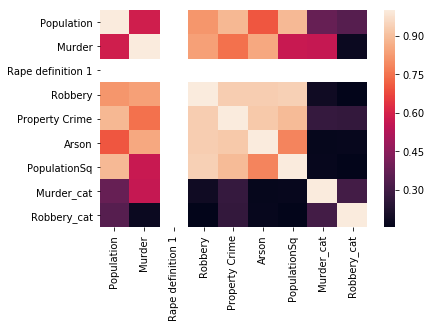

In [903]:
sns.heatmap(ny_crime.corr())

In [904]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
data = features[['Population', 'PopulationSq', 'Murder_cat', 'Robbery_cat']]
target = features['Property Crime']
regr.fit(data, target)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(data, target))


Coefficients: 
 [  1.40107315e-02   1.13425350e-07   8.42401093e+01   1.00084978e+02]

Intercept: 
 -20.7925867491

R-squared:
0.842104946287


In [905]:
# PCA
features_pca = ny_crime[['Population', 'PopulationSq', 'Murder_cat', 'Robbery_cat']].dropna()

# Normalize the data so that all variables have a mean of 0 and standard deviation
# of 1.
X = StandardScaler().fit_transform(features_pca)

# The NumPy covariance function assumes that variables are represented by rows,
# not columns, so we transpose X.
Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

Covariance Matrix:
 [[ 1.00289017  0.89115011  0.37542126  0.34534177]
 [ 0.89115011  1.00289017  0.16796569  0.15272868]
 [ 0.37542126  0.16796569  1.00289017  0.30310431]
 [ 0.34534177  0.15272868  0.30310431  1.00289017]]


In [906]:
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].reshape(1, 4).T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[[ 0.64190693]
 [ 0.57293405]
 [ 0.36955258]
 [ 0.35090306]]
Eigenvalue 1: 2.203203787327721
----------------------------------------
Eigenvector 2: 
[[ 0.73117427]
 [-0.65744738]
 [-0.13796011]
 [-0.11880296]]
Eigenvalue 2: 0.07465033477681791
----------------------------------------
Eigenvector 3: 
[[ 0.23088635]
 [ 0.48839321]
 [-0.57316047]
 [-0.61615796]]
Eigenvalue 3: 1.0343773248837143
----------------------------------------
Eigenvector 4: 
[[ 0.00558377]
 [ 0.03133038]
 [-0.71825133]
 [ 0.69505558]]
Eigenvalue 4: 0.6993292466533609
----------------------------------------
The percentage of total variance in the dataset explained by each component calculated by hand.
 [ 0.54921362  0.0186088   0.2578491   0.17432847]


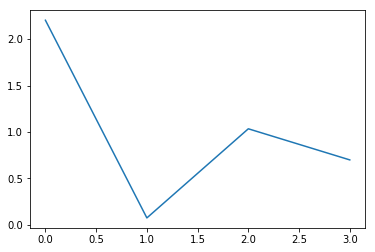

In [907]:
plt.plot(eig_val_cov)
plt.show()

Based upon our PCA, we should select only those features that have an eigenvalue greater than 1. Only two features satisfy this criteria - Population and Murder_cat. Thus, we can generate a soluation that encompasses over 80% of the variance in the data in just these two components, as opposed to using all four.

In [908]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
data = features[['Population', 'Murder_cat']]
target = features['Property Crime']
regr.fit(data, target)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(data, target))


Coefficients: 
 [  3.48836771e-02  -2.11668906e+02]

Intercept: 
 -142.815860829

R-squared:
0.79137474817


We achieve a similar R-squared value by using only two features instead of four.